In [4]:
pip install matplotlib

  Using cached matplotlib-3.9.4-cp39-cp39-win_amd64.whl.metadata (11 kB)
  Using cached contourpy-1.3.0-cp39-cp39-win_amd64.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached kiwisolver-1.4.7-cp39-cp39-win_amd64.whl.metadata (6.4 kB)
  Using cached pyparsing-3.2.1-py3-none-any.whl.metadata (5.0 kB)
  Using cached importlib_resources-6.5.2-py3-none-any.whl.metadata (3.9 kB)
Using cached matplotlib-3.9.4-cp39-cp39-win_amd64.whl (7.8 MB)
Using cached contourpy-1.3.0-cp39-cp39-win_amd64.whl (211 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   -------------- ------------------------- 0.8/2.2 MB 3.1 MB/s eta 0:00:01
   ---------------------------------------- 2.2/2.2 MB 4.6 MB/s eta 0:00:00
Using cached importlib_resources-6.5.2-py3-none-any.whl (37 kB)
Using cached kiwisolver-1.4.7-cp39-cp39-wi

In [6]:
pip install opencv-python

  Using cached opencv_python-4.11.0.86-cp37-abi3-win_amd64.whl.metadata (20 kB)
Using cached opencv_python-4.11.0.86-cp37-abi3-win_amd64.whl (39.5 MB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install scikit-image

  Using cached scikit_image-0.24.0-cp39-cp39-win_amd64.whl.metadata (14 kB)
  Using cached scipy-1.13.1-cp39-cp39-win_amd64.whl.metadata (60 kB)
  Using cached networkx-3.2.1-py3-none-any.whl.metadata (5.2 kB)
  Using cached imageio-2.37.0-py3-none-any.whl.metadata (5.2 kB)
  Using cached tifffile-2024.8.30-py3-none-any.whl.metadata (31 kB)
  Using cached lazy_loader-0.4-py3-none-any.whl.metadata (7.6 kB)
Using cached scikit_image-0.24.0-cp39-cp39-win_amd64.whl (12.9 MB)
Using cached imageio-2.37.0-py3-none-any.whl (315 kB)
Using cached lazy_loader-0.4-py3-none-any.whl (12 kB)
Using cached networkx-3.2.1-py3-none-any.whl (1.6 MB)
Using cached scipy-1.13.1-cp39-cp39-win_amd64.whl (46.2 MB)
Using cached tifffile-2024.8.30-py3-none-any.whl (227 kB)
Note: you may need to restart the kernel to use updated packages.


In [3]:
#1: Imports
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.ops import DeformConv2d
from torchmetrics.functional import peak_signal_noise_ratio, structural_similarity_index_measure
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import os
from skimage.feature import canny
import tqdm

print("All imports successful!")
print("PyTorch:", torch.__version__)
print("Torchvision:", torchvision.__version__)
print("CUDA:", torch.cuda.is_available())

All imports successful!
PyTorch: 1.12.1+cu113
Torchvision: 0.13.1+cu113
CUDA: True


In [4]:
#2: Edge Map Function
def get_edge_map(image):
    # Handle single ([C, H, W]) or batched ([B, C, H, W]) tensors
    image = image.detach().cpu()
    is_batched = len(image.shape) == 4
    
    if is_batched:
        batch_size = image.shape[0]
        edge_maps = []
        for i in range(batch_size):
            img_np = image[i].numpy().transpose(1, 2, 0)  # [C, H, W] -> [H, W, C]
            img_np = (img_np + 1) / 2  # [-1, 1] to [0, 1]
            edges = canny(img_np.mean(axis=2), sigma=2)
            edge_maps.append(torch.tensor(edges, dtype=torch.float32))
        return torch.stack(edge_maps, dim=0).unsqueeze(1).to(image.device)  # [B, 1, H, W]
    else:
        # Single image case
        img_np = image.numpy().transpose(1, 2, 0)  # [C, H, W] -> [H, W, C]
        img_np = (img_np + 1) / 2  # [-1, 1] to [0, 1]
        edges = canny(img_np.mean(axis=2), sigma=2)
        return torch.tensor(edges, dtype=torch.float32).unsqueeze(0).to(image.device)  # [1, H, W]

In [5]:
#3: Enhanced Generator

class DeformableBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.offset_conv = nn.Conv2d(in_channels, 2 * 3 * 3, 3, padding=1)
        self.deform_conv = DeformConv2d(in_channels, out_channels, 3, padding=1)
        self.norm = nn.GroupNorm(16, out_channels)
        self.relu = nn.LeakyReLU(0.2, inplace=True)
    
    def forward(self, x):
        offset = self.offset_conv(x)
        x = self.deform_conv(x, offset)
        x = self.norm(x)
        x = self.relu(x)
        return x

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, 3, padding=1)
        self.norm1 = nn.GroupNorm(16, channels)
        self.conv2 = nn.Conv2d(channels, channels, 3, padding=1)
        self.norm2 = nn.GroupNorm(16, channels)
    
    def forward(self, x):
        residual = x
        x = F.leaky_relu(self.norm1(self.conv1(x)), 0.2)
        x = self.norm2(self.conv2(x))
        return x + residual

class AttentionModule(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv = nn.Conv2d(channels, channels, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        attn = self.sigmoid(self.conv(x))
        return x * attn

class EnhancedGenerator(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder: Downsample to 64x64
        self.enc1 = nn.Conv2d(4, 64, 4, 2, 1)  # 256x256 -> 128x128
        self.enc2 = DeformableBlock(64, 128)    # 128x128
        self.enc3 = nn.Conv2d(128, 256, 4, 2, 1)  # 128x128 -> 64x64
        
        # Residual blocks at bottleneck
        self.res_blocks = nn.ModuleList([ResidualBlock(256) for _ in range(6)])
        self.attn = AttentionModule(256)
        
        # Decoder: Upsample back to 256x256
        self.dec3 = nn.ConvTranspose2d(256, 128, 4, 2, 1)  # 64x64 -> 128x128
        self.dec2 = DeformableBlock(128, 64)               # 128x128
        self.dec1 = nn.ConvTranspose2d(64, 3, 4, 2, 1)    # 128x128 -> 256x256
        
        self.tanh = nn.Tanh()
    
    def forward(self, x):
        e1 = F.leaky_relu(self.enc1(x), 0.2)
        e2 = self.enc2(e1)
        e3 = F.leaky_relu(self.enc3(e2), 0.2)
        
        r = e3
        for block in self.res_blocks:
            r = block(r)
        r = self.attn(r)
        
        d3 = F.leaky_relu(self.dec3(r), 0.2)
        d2 = self.dec2(d3)
        d1 = self.dec1(d2)
        
        return self.tanh(d1)

In [6]:
#4: Multi-Scale Discriminator
class MultiScaleDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.scale1 = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1), nn.GroupNorm(16, 128), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 1, 4, 1, 0), nn.Sigmoid()
        )
        self.scale2 = nn.Sequential(
            nn.AvgPool2d(2),
            nn.Conv2d(3, 64, 4, 2, 1), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1), nn.GroupNorm(16, 128), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 1, 4, 1, 0), nn.Sigmoid()
        )
    
    def forward(self, x):
        return [self.scale1(x), self.scale2(x)]

In [7]:
#5: Loss Functions
def compute_content_loss(fake, real):
    return F.l1_loss(fake, real)

# def compute_adversarial_loss(discriminator, fake, real):
#     real_out = discriminator(real)
#     fake_out = discriminator(fake)
#     loss = 0
#     for ro, fo in zip(real_out, fake_out):
#         loss += nn.BCELoss()(ro, torch.ones_like(ro)) + nn.BCELoss()(fo, torch.zeros_like(fo))
#     return loss / 2

def compute_perceptual_loss(fake, real):
    return F.mse_loss(fake, real)  # Simplified; use VGG if desired

def compute_edge_loss(fake, real):
    fake_edges = get_edge_map(fake)
    real_edges = get_edge_map(real)
    return F.l1_loss(fake_edges, real_edges)

# def compute_total_loss(generator, discriminator, fake, real):
#     c_loss = compute_content_loss(fake, real)
#     a_loss = compute_adversarial_loss(discriminator, fake, real)
#     p_loss = compute_perceptual_loss(fake, real)
#     e_loss = compute_edge_loss(fake, real)
#     lambda1, lambda2, lambda3, lambda4 = 1.0, 3.0, 0.01, 0.1
#     total_loss = (lambda1 * c_loss + lambda2 * a_loss + lambda3 * p_loss + lambda4 * e_loss)
#     return total_loss, c_loss, a_loss, p_loss, e_loss

# Cell 5: Updated Loss Functions with New Weights
def compute_adversarial_loss(discriminator, fake, real):
    fake_s1, fake_s2 = discriminator(fake)
    real_s1, real_s2 = discriminator(real)
    return (nn.BCEWithLogitsLoss()(fake_s1, torch.zeros_like(fake_s1)) + 
            nn.BCEWithLogitsLoss()(fake_s2, torch.zeros_like(fake_s2)) + 
            nn.BCEWithLogitsLoss()(real_s1, torch.ones_like(real_s1)) + 
            nn.BCEWithLogitsLoss()(real_s2, torch.ones_like(real_s2))) / 4

def compute_total_loss(generator, discriminator, fake, real):
    lambda1, lambda2, lambda3, lambda4 = 0.8, 1.0, 0.1, 0.5  # New weights
    c_loss = nn.L1Loss()(fake, real)
    fake_s1, fake_s2 = discriminator(fake)
    a_loss = (nn.BCEWithLogitsLoss()(fake_s1, torch.ones_like(fake_s1)) + 
              nn.BCEWithLogitsLoss()(fake_s2, torch.ones_like(fake_s2))) / 2
    p_loss = nn.MSELoss()(vgg16(fake), vgg16(real))  # Assume vgg16 defined
    e_loss = nn.L1Loss()(get_edge_map(fake), get_edge_map(real))
    g_loss = lambda1 * c_loss + lambda2 * a_loss + lambda3 * p_loss + lambda4 * e_loss
    return g_loss, c_loss, a_loss, p_loss, e_loss


In [8]:
#6: Dataset
class EUVPDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.distorted_images = []
        self.gt_images = []
        for subdir in os.listdir(root_dir):
            trainA_dir = os.path.join(root_dir, subdir, 'trainA')
            trainB_dir = os.path.join(root_dir, subdir, 'trainB')
            if os.path.isdir(trainA_dir) and os.path.isdir(trainB_dir):
                trainA_files = sorted(os.listdir(trainA_dir))
                trainB_files = sorted(os.listdir(trainB_dir))
                assert len(trainA_files) == len(trainB_files), f"Mismatch in {subdir}"
                self.distorted_images.extend(os.path.join(trainA_dir, f) for f in trainA_files)
                self.gt_images.extend(os.path.join(trainB_dir, f) for f in trainB_files)
        assert len(self.distorted_images) == len(self.gt_images), "Total mismatch"
        print(f"Total images loaded: {len(self.distorted_images)}")
    
    def __len__(self):
        return len(self.distorted_images)
    
    def __getitem__(self, idx):
        distorted = Image.open(self.distorted_images[idx]).convert('RGB')
        gt = Image.open(self.gt_images[idx]).convert('RGB')
        if self.transform:
            distorted = self.transform(distorted)
            gt = self.transform(gt)
        edge_map = get_edge_map(distorted).to(distorted.device)
        distorted = torch.cat([distorted, edge_map], dim=0)  # [4, 256, 256]
        return distorted, gt

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = EUVPDataset(
    r'C:\Users\plawa\anaconda3\envs\underwater_gan_new\EUVP\Paired',
    transform=transform
)
train_loader = DataLoader(dataset, batch_size=4, shuffle=True)

Total images loaded: 11435


In [9]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = EnhancedGenerator().to(device)
discriminator = MultiScaleDiscriminator().to(device)

g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.00002, betas=(0.5, 0.999))

In [21]:
#7: Training Loop

num_epochs = 20
for epoch in range(num_epochs):
    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]")
    
    for i, (distorted, ground_truth) in enumerate(train_loader_tqdm):
        distorted, ground_truth = distorted.to(device), ground_truth.to(device)
        if i == 0 and epoch == 0:
            print(f"Batch shapes - Distorted: {distorted.shape}, Ground truth: {ground_truth.shape}")
        
        if i % 25 == 0:
            d_optimizer.zero_grad()
            with torch.no_grad():
                fake = generator(distorted)
            if i == 0 and epoch == 0:
                print(f"Fake shape (disc): {fake.shape}")
            real_noise = ground_truth + torch.randn_like(ground_truth) * 0.1
            fake_noise = fake.detach() + torch.randn_like(fake) * 0.1
            d_loss = compute_adversarial_loss(discriminator, fake_noise, real_noise)
            d_loss.backward()
            torch.nn.utils.clip_grad_norm_(discriminator.parameters(), max_norm=1.0)
            d_optimizer.step()
        
        g_optimizer.zero_grad()
        fake = generator(distorted)
        if i == 0 and epoch == 0:
            print(f"Fake shape (gen): {fake.shape}")
        g_loss, c_loss, a_loss, p_loss, e_loss = compute_total_loss(generator, discriminator, fake, ground_truth)
        g_loss.backward()
        torch.nn.utils.clip_grad_norm_(generator.parameters(), max_norm=1.0)
        g_optimizer.step()
        
        if i % 10 == 0:
            with torch.no_grad():
                psnr = peak_signal_noise_ratio(fake, ground_truth, data_range=2.0).item()
                ssim = structural_similarity_index_measure(fake, ground_truth, data_range=2.0).item()
            train_loader_tqdm.set_postfix({
                'D Loss': f'{d_loss.item():.4f}',
                'G Loss': f'{g_loss.item():.4f}',
                'C Loss': f'{c_loss.item():.4f}',
                'A Loss': f'{a_loss.item():.4f}',
                'P Loss': f'{p_loss.item():.4f}',
                'E Loss': f'{e_loss.item():.4f}',
                'PSNR': f'{psnr:.2f}',
                'SSIM': f'{ssim:.4f}'
            })
    
    torch.save(generator.state_dict(), f"generator_epoch_{epoch+1}.pth")
    torch.save(discriminator.state_dict(), f"discriminator_epoch_{epoch+1}.pth")
    print(f"Epoch [{epoch+1}/{num_epochs}] completed. Saved models.")

print("Training completed!")

Epoch [1/100]:   0%|          | 0/2859 [00:00<?, ?it/s]

Batch shapes - Distorted: torch.Size([4, 4, 256, 256]), Ground truth: torch.Size([4, 3, 256, 256])
Fake shape (disc): torch.Size([4, 3, 256, 256])
Fake shape (gen): torch.Size([4, 3, 256, 256])


Epoch [1/100]: 100%|██████████| 2859/2859 [12:08<00:00,  3.93it/s, D Loss=0.0396, G Loss=0.3762, C Loss=0.2613, A Loss=0.0355, P Loss=0.1536, E Loss=0.0687, PSNR=14.16, SSIM=0.1184]


Epoch [1/100] completed. Saved models.


Epoch [2/100]: 100%|██████████| 2859/2859 [12:24<00:00,  3.84it/s, D Loss=0.0156, G Loss=0.1876, C Loss=0.1460, A Loss=0.0124, P Loss=0.0385, E Loss=0.0403, PSNR=20.16, SSIM=0.2805]


Epoch [2/100] completed. Saved models.


Epoch [3/100]: 100%|██████████| 2859/2859 [11:53<00:00,  4.01it/s, D Loss=0.0100, G Loss=0.1827, C Loss=0.1529, A Loss=0.0082, P Loss=0.0430, E Loss=0.0483, PSNR=19.69, SSIM=0.3998]


Epoch [3/100] completed. Saved models.


Epoch [4/100]: 100%|██████████| 2859/2859 [11:38<00:00,  4.10it/s, D Loss=0.0078, G Loss=0.1432, C Loss=0.1230, A Loss=0.0055, P Loss=0.0310, E Loss=0.0327, PSNR=21.10, SSIM=0.4741]


Epoch [4/100] completed. Saved models.


Epoch [5/100]: 100%|██████████| 2859/2859 [11:40<00:00,  4.08it/s, D Loss=0.0043, G Loss=0.1070, C Loss=0.0956, A Loss=0.0026, P Loss=0.0163, E Loss=0.0342, PSNR=23.89, SSIM=0.5935]


Epoch [5/100] completed. Saved models.


Epoch [6/100]: 100%|██████████| 2859/2859 [11:33<00:00,  4.13it/s, D Loss=0.0073, G Loss=0.1213, C Loss=0.1030, A Loss=0.0046, P Loss=0.0174, E Loss=0.0432, PSNR=23.61, SSIM=0.6706]


Epoch [6/100] completed. Saved models.


Epoch [7/100]: 100%|██████████| 2859/2859 [11:05<00:00,  4.30it/s, D Loss=0.0047, G Loss=0.1453, C Loss=0.1323, A Loss=0.0028, P Loss=0.0347, E Loss=0.0419, PSNR=20.62, SSIM=0.6397]


Epoch [7/100] completed. Saved models.


Epoch [8/100]: 100%|██████████| 2859/2859 [11:11<00:00,  4.26it/s, D Loss=0.0043, G Loss=0.1052, C Loss=0.0962, A Loss=0.0020, P Loss=0.0163, E Loss=0.0266, PSNR=23.89, SSIM=0.6428]


Epoch [8/100] completed. Saved models.


Epoch [9/100]: 100%|██████████| 2859/2859 [11:01<00:00,  4.32it/s, D Loss=0.0045, G Loss=0.1490, C Loss=0.1407, A Loss=0.0014, P Loss=0.0522, E Loss=0.0368, PSNR=18.84, SSIM=0.5996]


Epoch [9/100] completed. Saved models.


Epoch [10/100]: 100%|██████████| 2859/2859 [11:02<00:00,  4.32it/s, D Loss=0.0057, G Loss=0.1235, C Loss=0.1114, A Loss=0.0027, P Loss=0.0298, E Loss=0.0374, PSNR=21.28, SSIM=0.6500]


Epoch [10/100] completed. Saved models.


Epoch [11/100]: 100%|██████████| 2859/2859 [12:38<00:00,  3.77it/s, D Loss=0.0048, G Loss=0.0897, C Loss=0.0823, A Loss=0.0013, P Loss=0.0113, E Loss=0.0328, PSNR=25.50, SSIM=0.6730]  


Epoch [11/100] completed. Saved models.


Epoch [12/100]: 100%|██████████| 2859/2859 [11:34<00:00,  4.12it/s, D Loss=0.0077, G Loss=0.1070, C Loss=0.0963, A Loss=0.0021, P Loss=0.0211, E Loss=0.0419, PSNR=22.77, SSIM=0.6911]


Epoch [12/100] completed. Saved models.


Epoch [13/100]: 100%|██████████| 2859/2859 [11:29<00:00,  4.14it/s, D Loss=0.0078, G Loss=0.1375, C Loss=0.1226, A Loss=0.0038, P Loss=0.0270, E Loss=0.0335, PSNR=21.71, SSIM=0.6392]


Epoch [13/100] completed. Saved models.


Epoch [14/100]: 100%|██████████| 2859/2859 [11:29<00:00,  4.15it/s, D Loss=0.0061, G Loss=0.1113, C Loss=0.0942, A Loss=0.0044, P Loss=0.0189, E Loss=0.0370, PSNR=23.26, SSIM=0.7820]


Epoch [14/100] completed. Saved models.


Epoch [15/100]: 100%|██████████| 2859/2859 [11:39<00:00,  4.09it/s, D Loss=0.0062, G Loss=0.1239, C Loss=0.1163, A Loss=0.0013, P Loss=0.0266, E Loss=0.0327, PSNR=21.77, SSIM=0.6601]


Epoch [15/100] completed. Saved models.


Epoch [16/100]: 100%|██████████| 2859/2859 [12:20<00:00,  3.86it/s, D Loss=0.0083, G Loss=0.1403, C Loss=0.1247, A Loss=0.0042, P Loss=0.0284, E Loss=0.0276, PSNR=21.48, SSIM=0.6569]


Epoch [16/100] completed. Saved models.


Epoch [17/100]: 100%|██████████| 2859/2859 [12:12<00:00,  3.90it/s, D Loss=0.0115, G Loss=0.1751, C Loss=0.1573, A Loss=0.0048, P Loss=0.0568, E Loss=0.0266, PSNR=18.48, SSIM=0.7097]


Epoch [17/100] completed. Saved models.


Epoch [18/100]: 100%|██████████| 2859/2859 [12:16<00:00,  3.88it/s, D Loss=0.0053, G Loss=0.1043, C Loss=0.0948, A Loss=0.0021, P Loss=0.0177, E Loss=0.0288, PSNR=23.54, SSIM=0.7841]


Epoch [18/100] completed. Saved models.


Epoch [19/100]: 100%|██████████| 2859/2859 [15:19<00:00,  3.11it/s, D Loss=0.0057, G Loss=0.1224, C Loss=0.1169, A Loss=0.0007, P Loss=0.0438, E Loss=0.0279, PSNR=19.60, SSIM=0.7578]


Epoch [19/100] completed. Saved models.


Epoch [20/100]: 100%|██████████| 2859/2859 [12:28<00:00,  3.82it/s, D Loss=0.0064, G Loss=0.0897, C Loss=0.0811, A Loss=0.0017, P Loss=0.0135, E Loss=0.0343, PSNR=24.72, SSIM=0.7744]


Epoch [20/100] completed. Saved models.


Epoch [21/100]: 100%|██████████| 2859/2859 [10:59<00:00,  4.33it/s, D Loss=0.0053, G Loss=0.1048, C Loss=0.0981, A Loss=0.0007, P Loss=0.0224, E Loss=0.0443, PSNR=22.51, SSIM=0.7623]


Epoch [21/100] completed. Saved models.


Epoch [22/100]: 100%|██████████| 2859/2859 [11:04<00:00,  4.30it/s, D Loss=0.0078, G Loss=0.0990, C Loss=0.0867, A Loss=0.0025, P Loss=0.0143, E Loss=0.0466, PSNR=24.46, SSIM=0.7331]


Epoch [22/100] completed. Saved models.


Epoch [23/100]: 100%|██████████| 2859/2859 [10:59<00:00,  4.33it/s, D Loss=0.0047, G Loss=0.0874, C Loss=0.0830, A Loss=0.0006, P Loss=0.0117, E Loss=0.0262, PSNR=25.35, SSIM=0.7606]


Epoch [23/100] completed. Saved models.


Epoch [24/100]: 100%|██████████| 2859/2859 [10:59<00:00,  4.33it/s, D Loss=0.0041, G Loss=0.0923, C Loss=0.0867, A Loss=0.0007, P Loss=0.0153, E Loss=0.0352, PSNR=24.18, SSIM=0.7967]


Epoch [24/100] completed. Saved models.


Epoch [25/100]: 100%|██████████| 2859/2859 [10:58<00:00,  4.34it/s, D Loss=0.0011, G Loss=0.2295, C Loss=0.2250, A Loss=0.0001, P Loss=0.0996, E Loss=0.0326, PSNR=16.04, SSIM=0.4352]


Epoch [25/100] completed. Saved models.


Epoch [26/100]: 100%|██████████| 2859/2859 [11:01<00:00,  4.32it/s, D Loss=0.0103, G Loss=0.1144, C Loss=0.1050, A Loss=0.0018, P Loss=0.0213, E Loss=0.0369, PSNR=22.74, SSIM=0.6595]


Epoch [26/100] completed. Saved models.


Epoch [27/100]: 100%|██████████| 2859/2859 [11:23<00:00,  4.18it/s, D Loss=0.0017, G Loss=0.1065, C Loss=0.1021, A Loss=0.0001, P Loss=0.0179, E Loss=0.0391, PSNR=23.49, SSIM=0.7018]


Epoch [27/100] completed. Saved models.


Epoch [28/100]: 100%|██████████| 2859/2859 [11:39<00:00,  4.08it/s, D Loss=0.0083, G Loss=0.0972, C Loss=0.0926, A Loss=0.0006, P Loss=0.0198, E Loss=0.0254, PSNR=23.04, SSIM=0.7392]


Epoch [28/100] completed. Saved models.


Epoch [29/100]: 100%|██████████| 2859/2859 [11:37<00:00,  4.10it/s, D Loss=0.0027, G Loss=0.1054, C Loss=0.1013, A Loss=0.0003, P Loss=0.0214, E Loss=0.0292, PSNR=22.72, SSIM=0.7070]


Epoch [29/100] completed. Saved models.


Epoch [30/100]: 100%|██████████| 2859/2859 [11:36<00:00,  4.10it/s, D Loss=0.0024, G Loss=0.0822, C Loss=0.0774, A Loss=0.0004, P Loss=0.0108, E Loss=0.0359, PSNR=25.70, SSIM=0.7795]


Epoch [30/100] completed. Saved models.


Epoch [31/100]: 100%|██████████| 2859/2859 [11:37<00:00,  4.10it/s, D Loss=0.0784, G Loss=0.0766, C Loss=0.0702, A Loss=0.0012, P Loss=0.0134, E Loss=0.0281, PSNR=24.77, SSIM=0.7777]


Epoch [31/100] completed. Saved models.


Epoch [32/100]: 100%|██████████| 2859/2859 [11:42<00:00,  4.07it/s, D Loss=0.0108, G Loss=0.0875, C Loss=0.0832, A Loss=0.0003, P Loss=0.0164, E Loss=0.0328, PSNR=23.86, SSIM=0.7787]


Epoch [32/100] completed. Saved models.


Epoch [33/100]: 100%|██████████| 2859/2859 [23:23<00:00,  2.04it/s, D Loss=0.0018, G Loss=0.0870, C Loss=0.0820, A Loss=0.0001, P Loss=0.0127, E Loss=0.0449, PSNR=25.00, SSIM=0.7608]  


Epoch [33/100] completed. Saved models.


Epoch [34/100]: 100%|██████████| 2859/2859 [12:49<00:00,  3.72it/s, D Loss=0.0039, G Loss=0.1210, C Loss=0.1146, A Loss=0.0011, P Loss=0.0241, E Loss=0.0298, PSNR=22.20, SSIM=0.7132]


Epoch [34/100] completed. Saved models.


Epoch [35/100]: 100%|██████████| 2859/2859 [13:32<00:00,  3.52it/s, D Loss=0.0147, G Loss=0.1171, C Loss=0.0893, A Loss=0.0081, P Loss=0.0172, E Loss=0.0347, PSNR=23.66, SSIM=0.7564]


Epoch [35/100] completed. Saved models.


Epoch [36/100]: 100%|██████████| 2859/2859 [13:12<00:00,  3.61it/s, D Loss=0.0070, G Loss=0.0996, C Loss=0.0835, A Loss=0.0038, P Loss=0.0141, E Loss=0.0457, PSNR=24.53, SSIM=0.7739]


Epoch [36/100] completed. Saved models.


Epoch [37/100]: 100%|██████████| 2859/2859 [11:50<00:00,  4.02it/s, D Loss=0.0065, G Loss=0.1282, C Loss=0.1211, A Loss=0.0010, P Loss=0.0480, E Loss=0.0363, PSNR=19.21, SSIM=0.7550]


Epoch [37/100] completed. Saved models.


Epoch [38/100]: 100%|██████████| 2859/2859 [11:53<00:00,  4.01it/s, D Loss=0.0042, G Loss=0.0922, C Loss=0.0841, A Loss=0.0013, P Loss=0.0165, E Loss=0.0411, PSNR=23.84, SSIM=0.7905]


Epoch [38/100] completed. Saved models.


Epoch [39/100]: 100%|██████████| 2859/2859 [11:51<00:00,  4.02it/s, D Loss=0.0032, G Loss=0.0914, C Loss=0.0852, A Loss=0.0007, P Loss=0.0184, E Loss=0.0380, PSNR=23.38, SSIM=0.7849]


Epoch [39/100] completed. Saved models.


Epoch [40/100]: 100%|██████████| 2859/2859 [11:55<00:00,  3.99it/s, D Loss=0.0012, G Loss=0.1250, C Loss=0.1192, A Loss=0.0004, P Loss=0.0259, E Loss=0.0450, PSNR=21.89, SSIM=0.7170]


Epoch [40/100] completed. Saved models.


Epoch [41/100]: 100%|██████████| 2859/2859 [11:52<00:00,  4.02it/s, D Loss=0.0039, G Loss=0.0963, C Loss=0.0871, A Loss=0.0018, P Loss=0.0242, E Loss=0.0366, PSNR=22.18, SSIM=0.7865]


Epoch [41/100] completed. Saved models.


Epoch [42/100]: 100%|██████████| 2859/2859 [12:15<00:00,  3.89it/s, D Loss=0.0145, G Loss=0.0869, C Loss=0.0732, A Loss=0.0036, P Loss=0.0100, E Loss=0.0275, PSNR=26.04, SSIM=0.7962]


Epoch [42/100] completed. Saved models.


Epoch [43/100]: 100%|██████████| 2859/2859 [14:54<00:00,  3.20it/s, D Loss=0.0022, G Loss=0.1006, C Loss=0.0921, A Loss=0.0017, P Loss=0.0189, E Loss=0.0329, PSNR=23.26, SSIM=0.7760]


Epoch [43/100] completed. Saved models.


Epoch [44/100]: 100%|██████████| 2859/2859 [11:51<00:00,  4.02it/s, D Loss=0.0015, G Loss=0.0889, C Loss=0.0844, A Loss=0.0003, P Loss=0.0150, E Loss=0.0356, PSNR=24.26, SSIM=0.7612]


Epoch [44/100] completed. Saved models.


Epoch [45/100]: 100%|██████████| 2859/2859 [11:12<00:00,  4.25it/s, D Loss=0.0043, G Loss=0.0868, C Loss=0.0809, A Loss=0.0010, P Loss=0.0111, E Loss=0.0279, PSNR=25.55, SSIM=0.7590]


Epoch [45/100] completed. Saved models.


Epoch [46/100]: 100%|██████████| 2859/2859 [47:47<00:00,  1.00s/it, D Loss=0.0022, G Loss=0.0712, C Loss=0.0653, A Loss=0.0007, P Loss=0.0079, E Loss=0.0375, PSNR=27.02, SSIM=0.8301]    


Epoch [46/100] completed. Saved models.


Epoch [47/100]: 100%|██████████| 2859/2859 [13:29<00:00,  3.53it/s, D Loss=0.0004, G Loss=0.1101, C Loss=0.1060, A Loss=0.0000, P Loss=0.0303, E Loss=0.0363, PSNR=21.21, SSIM=0.6622]


Epoch [47/100] completed. Saved models.


Epoch [48/100]: 100%|██████████| 2859/2859 [12:46<00:00,  3.73it/s, D Loss=0.0011, G Loss=0.1012, C Loss=0.0969, A Loss=0.0002, P Loss=0.0197, E Loss=0.0362, PSNR=23.08, SSIM=0.7749]


Epoch [48/100] completed. Saved models.


Epoch [49/100]: 100%|██████████| 2859/2859 [11:51<00:00,  4.02it/s, D Loss=0.0014, G Loss=0.1100, C Loss=0.1046, A Loss=0.0005, P Loss=0.0296, E Loss=0.0363, PSNR=21.30, SSIM=0.7697]


Epoch [49/100] completed. Saved models.


Epoch [50/100]: 100%|██████████| 2859/2859 [11:49<00:00,  4.03it/s, D Loss=0.0020, G Loss=0.0792, C Loss=0.0750, A Loss=0.0004, P Loss=0.0161, E Loss=0.0299, PSNR=23.95, SSIM=0.8312]


Epoch [50/100] completed. Saved models.


Epoch [51/100]: 100%|██████████| 2859/2859 [11:55<00:00,  4.00it/s, D Loss=0.0035, G Loss=0.1001, C Loss=0.0944, A Loss=0.0006, P Loss=0.0203, E Loss=0.0376, PSNR=22.95, SSIM=0.7080]


Epoch [51/100] completed. Saved models.


Epoch [52/100]: 100%|██████████| 2859/2859 [11:55<00:00,  4.00it/s, D Loss=0.0021, G Loss=0.0846, C Loss=0.0795, A Loss=0.0002, P Loss=0.0133, E Loss=0.0429, PSNR=24.79, SSIM=0.7762]


Epoch [52/100] completed. Saved models.


Epoch [53/100]: 100%|██████████| 2859/2859 [11:44<00:00,  4.06it/s, D Loss=0.0021, G Loss=0.0681, C Loss=0.0626, A Loss=0.0007, P Loss=0.0074, E Loss=0.0316, PSNR=27.34, SSIM=0.8404]


Epoch [53/100] completed. Saved models.


Epoch [54/100]: 100%|██████████| 2859/2859 [11:24<00:00,  4.18it/s, D Loss=0.0023, G Loss=0.0957, C Loss=0.0900, A Loss=0.0006, P Loss=0.0159, E Loss=0.0366, PSNR=24.00, SSIM=0.7855]


Epoch [54/100] completed. Saved models.


Epoch [55/100]: 100%|██████████| 2859/2859 [11:30<00:00,  4.14it/s, D Loss=0.0008, G Loss=0.0732, C Loss=0.0697, A Loss=0.0001, P Loss=0.0097, E Loss=0.0326, PSNR=26.15, SSIM=0.7993]


Epoch [55/100] completed. Saved models.


Epoch [56/100]: 100%|██████████| 2859/2859 [11:33<00:00,  4.12it/s, D Loss=0.0025, G Loss=0.0772, C Loss=0.0721, A Loss=0.0006, P Loss=0.0096, E Loss=0.0319, PSNR=26.18, SSIM=0.8020]


Epoch [56/100] completed. Saved models.


Epoch [57/100]: 100%|██████████| 2859/2859 [11:32<00:00,  4.13it/s, D Loss=0.0013, G Loss=0.1254, C Loss=0.1213, A Loss=0.0001, P Loss=0.0320, E Loss=0.0344, PSNR=20.97, SSIM=0.7230]


Epoch [57/100] completed. Saved models.


Epoch [58/100]: 100%|██████████| 2859/2859 [11:40<00:00,  4.08it/s, D Loss=0.0021, G Loss=0.0922, C Loss=0.0856, A Loss=0.0010, P Loss=0.0230, E Loss=0.0339, PSNR=22.41, SSIM=0.7647]


Epoch [58/100] completed. Saved models.


Epoch [59/100]: 100%|██████████| 2859/2859 [11:39<00:00,  4.09it/s, D Loss=0.0057, G Loss=0.0727, C Loss=0.0629, A Loss=0.0023, P Loss=0.0092, E Loss=0.0277, PSNR=26.38, SSIM=0.8518]


Epoch [59/100] completed. Saved models.


Epoch [60/100]: 100%|██████████| 2859/2859 [11:30<00:00,  4.14it/s, D Loss=0.0004, G Loss=0.1033, C Loss=0.1001, A Loss=0.0001, P Loss=0.0236, E Loss=0.0272, PSNR=22.29, SSIM=0.7482]


Epoch [60/100] completed. Saved models.


Epoch [61/100]: 100%|██████████| 2859/2859 [12:57<00:00,  3.68it/s, D Loss=0.0004, G Loss=0.0822, C Loss=0.0780, A Loss=0.0001, P Loss=0.0113, E Loss=0.0372, PSNR=25.50, SSIM=0.7604]


Epoch [61/100] completed. Saved models.


Epoch [62/100]: 100%|██████████| 2859/2859 [11:18<00:00,  4.21it/s, D Loss=0.0014, G Loss=0.0738, C Loss=0.0701, A Loss=0.0002, P Loss=0.0090, E Loss=0.0303, PSNR=26.47, SSIM=0.8490]


Epoch [62/100] completed. Saved models.


Epoch [63/100]: 100%|██████████| 2859/2859 [2:06:02<00:00,  2.65s/it, D Loss=0.0004, G Loss=0.0850, C Loss=0.0802, A Loss=0.0001, P Loss=0.0118, E Loss=0.0436, PSNR=25.31, SSIM=0.7691]   


Epoch [63/100] completed. Saved models.


Epoch [64/100]: 100%|██████████| 2859/2859 [7:01:15<00:00,  8.84s/it, D Loss=0.0004, G Loss=0.0946, C Loss=0.0898, A Loss=0.0001, P Loss=0.0221, E Loss=0.0429, PSNR=22.57, SSIM=0.7714]    6]


Epoch [64/100] completed. Saved models.


Epoch [65/100]: 100%|██████████| 2859/2859 [5:44:26<00:00,  7.23s/it, D Loss=0.0035, G Loss=0.0777, C Loss=0.0717, A Loss=0.0008, P Loss=0.0092, E Loss=0.0364, PSNR=26.40, SSIM=0.8082]      


Epoch [65/100] completed. Saved models.


Epoch [66/100]: 100%|██████████| 2859/2859 [11:23<00:00,  4.18it/s, D Loss=0.0003, G Loss=0.0895, C Loss=0.0857, A Loss=0.0001, P Loss=0.0166, E Loss=0.0328, PSNR=23.83, SSIM=0.7818]


Epoch [66/100] completed. Saved models.


Epoch [67/100]: 100%|██████████| 2859/2859 [1:22:54<00:00,  1.74s/it, D Loss=0.0008, G Loss=0.0826, C Loss=0.0787, A Loss=0.0002, P Loss=0.0139, E Loss=0.0320, PSNR=24.58, SSIM=0.8077]     


Epoch [67/100] completed. Saved models.


Epoch [68/100]: 100%|██████████| 2859/2859 [13:01<00:00,  3.66it/s, D Loss=0.0004, G Loss=0.0847, C Loss=0.0812, A Loss=0.0000, P Loss=0.0158, E Loss=0.0321, PSNR=24.03, SSIM=0.7656]


Epoch [68/100] completed. Saved models.


Epoch [69/100]: 100%|██████████| 2859/2859 [14:37<00:00,  3.26it/s, D Loss=0.0005, G Loss=0.0914, C Loss=0.0865, A Loss=0.0001, P Loss=0.0219, E Loss=0.0437, PSNR=22.62, SSIM=0.7687]


Epoch [69/100] completed. Saved models.


Epoch [70/100]: 100%|██████████| 2859/2859 [13:41<00:00,  3.48it/s, D Loss=0.0002, G Loss=0.1153, C Loss=0.1113, A Loss=0.0001, P Loss=0.0287, E Loss=0.0355, PSNR=21.45, SSIM=0.7377]


Epoch [70/100] completed. Saved models.


Epoch [71/100]: 100%|██████████| 2859/2859 [12:36<00:00,  3.78it/s, D Loss=0.0003, G Loss=0.0876, C Loss=0.0834, A Loss=0.0000, P Loss=0.0196, E Loss=0.0379, PSNR=23.10, SSIM=0.7662]


Epoch [71/100] completed. Saved models.


Epoch [72/100]: 100%|██████████| 2859/2859 [13:20<00:00,  3.57it/s, D Loss=0.0003, G Loss=0.0734, C Loss=0.0697, A Loss=0.0001, P Loss=0.0116, E Loss=0.0338, PSNR=25.37, SSIM=0.7997]


Epoch [72/100] completed. Saved models.


Epoch [73/100]: 100%|██████████| 2859/2859 [12:42<00:00,  3.75it/s, D Loss=0.0011, G Loss=0.0718, C Loss=0.0675, A Loss=0.0001, P Loss=0.0099, E Loss=0.0394, PSNR=26.05, SSIM=0.8063]


Epoch [73/100] completed. Saved models.


Epoch [74/100]: 100%|██████████| 2859/2859 [14:43<00:00,  3.24it/s, D Loss=0.0007, G Loss=0.0950, C Loss=0.0911, A Loss=0.0001, P Loss=0.0215, E Loss=0.0348, PSNR=22.71, SSIM=0.7521]


Epoch [74/100] completed. Saved models.


Epoch [75/100]: 100%|██████████| 2859/2859 [12:34<00:00,  3.79it/s, D Loss=0.0002, G Loss=0.0966, C Loss=0.0923, A Loss=0.0001, P Loss=0.0174, E Loss=0.0394, PSNR=23.62, SSIM=0.7637]


Epoch [75/100] completed. Saved models.


Epoch [76/100]: 100%|██████████| 2859/2859 [17:25<00:00,  2.73it/s, D Loss=0.0016, G Loss=0.0983, C Loss=0.0937, A Loss=0.0001, P Loss=0.0164, E Loss=0.0418, PSNR=23.88, SSIM=0.7084]


Epoch [76/100] completed. Saved models.


Epoch [77/100]: 100%|██████████| 2859/2859 [28:04<00:00,  1.70it/s, D Loss=0.0010, G Loss=0.0771, C Loss=0.0726, A Loss=0.0001, P Loss=0.0100, E Loss=0.0398, PSNR=26.01, SSIM=0.8134]


Epoch [77/100] completed. Saved models.


Epoch [78/100]: 100%|██████████| 2859/2859 [13:02<00:00,  3.65it/s, D Loss=0.0016, G Loss=0.0715, C Loss=0.0668, A Loss=0.0006, P Loss=0.0091, E Loss=0.0283, PSNR=26.45, SSIM=0.8101]


Epoch [78/100] completed. Saved models.


Epoch [79/100]: 100%|██████████| 2859/2859 [13:01<00:00,  3.66it/s, D Loss=0.0009, G Loss=0.0779, C Loss=0.0744, A Loss=0.0001, P Loss=0.0111, E Loss=0.0299, PSNR=25.55, SSIM=0.7860]


Epoch [79/100] completed. Saved models.


Epoch [80/100]: 100%|██████████| 2859/2859 [12:14<00:00,  3.90it/s, D Loss=0.0001, G Loss=0.1078, C Loss=0.1035, A Loss=0.0000, P Loss=0.0288, E Loss=0.0405, PSNR=21.43, SSIM=0.7228]


Epoch [80/100] completed. Saved models.


Epoch [81/100]: 100%|██████████| 2859/2859 [1:00:43<00:00,  1.27s/it, D Loss=0.0009, G Loss=0.1255, C Loss=0.1200, A Loss=0.0003, P Loss=0.0398, E Loss=0.0414, PSNR=20.03, SSIM=0.7471]  


Epoch [81/100] completed. Saved models.


Epoch [82/100]: 100%|██████████| 2859/2859 [12:33<00:00,  3.80it/s, D Loss=0.0001, G Loss=0.0637, C Loss=0.0599, A Loss=0.0000, P Loss=0.0076, E Loss=0.0362, PSNR=27.21, SSIM=0.8326] 


Epoch [82/100] completed. Saved models.


Epoch [83/100]: 100%|██████████| 2859/2859 [14:33<00:00,  3.27it/s, D Loss=0.0011, G Loss=0.0583, C Loss=0.0540, A Loss=0.0002, P Loss=0.0054, E Loss=0.0359, PSNR=28.68, SSIM=0.8159]


Epoch [83/100] completed. Saved models.


Epoch [84/100]: 100%|██████████| 2859/2859 [13:19<00:00,  3.58it/s, D Loss=0.0006, G Loss=0.0973, C Loss=0.0932, A Loss=0.0001, P Loss=0.0215, E Loss=0.0357, PSNR=22.70, SSIM=0.7896]


Epoch [84/100] completed. Saved models.


Epoch [85/100]: 100%|██████████| 2859/2859 [12:11<00:00,  3.91it/s, D Loss=0.0004, G Loss=0.0780, C Loss=0.0735, A Loss=0.0001, P Loss=0.0113, E Loss=0.0401, PSNR=25.49, SSIM=0.7809]


Epoch [85/100] completed. Saved models.


Epoch [86/100]: 100%|██████████| 2859/2859 [13:08<00:00,  3.62it/s, D Loss=0.0005, G Loss=0.0693, C Loss=0.0655, A Loss=0.0002, P Loss=0.0088, E Loss=0.0306, PSNR=26.59, SSIM=0.8092]


Epoch [86/100] completed. Saved models.


Epoch [87/100]: 100%|██████████| 2859/2859 [14:14<00:00,  3.35it/s, D Loss=0.0006, G Loss=0.0705, C Loss=0.0674, A Loss=0.0001, P Loss=0.0095, E Loss=0.0285, PSNR=26.25, SSIM=0.8371]


Epoch [87/100] completed. Saved models.


Epoch [88/100]: 100%|██████████| 2859/2859 [28:26<00:00,  1.68it/s, D Loss=0.0006, G Loss=0.0801, C Loss=0.0764, A Loss=0.0001, P Loss=0.0138, E Loss=0.0335, PSNR=24.62, SSIM=0.8055]    


Epoch [88/100] completed. Saved models.


Epoch [89/100]: 100%|██████████| 2859/2859 [11:24<00:00,  4.18it/s, D Loss=0.0002, G Loss=0.0678, C Loss=0.0636, A Loss=0.0000, P Loss=0.0085, E Loss=0.0397, PSNR=26.73, SSIM=0.8725]


Epoch [89/100] completed. Saved models.


Epoch [90/100]: 100%|██████████| 2859/2859 [11:58<00:00,  3.98it/s, D Loss=0.0003, G Loss=0.0573, C Loss=0.0541, A Loss=0.0000, P Loss=0.0058, E Loss=0.0296, PSNR=28.38, SSIM=0.8480]


Epoch [90/100] completed. Saved models.


Epoch [91/100]: 100%|██████████| 2859/2859 [31:48<00:00,  1.50it/s, D Loss=0.0003, G Loss=0.1009, C Loss=0.0971, A Loss=0.0000, P Loss=0.0247, E Loss=0.0345, PSNR=22.09, SSIM=0.7415]     


Epoch [91/100] completed. Saved models.


Epoch [92/100]: 100%|██████████| 2859/2859 [12:02<00:00,  3.96it/s, D Loss=0.0003, G Loss=0.0708, C Loss=0.0675, A Loss=0.0000, P Loss=0.0099, E Loss=0.0319, PSNR=26.09, SSIM=0.8170]


Epoch [92/100] completed. Saved models.


Epoch [93/100]: 100%|██████████| 2859/2859 [12:56<00:00,  3.68it/s, D Loss=0.0002, G Loss=0.0812, C Loss=0.0774, A Loss=0.0000, P Loss=0.0114, E Loss=0.0355, PSNR=25.45, SSIM=0.7901]


Epoch [93/100] completed. Saved models.


Epoch [94/100]: 100%|██████████| 2859/2859 [12:17<00:00,  3.87it/s, D Loss=0.0001, G Loss=0.0835, C Loss=0.0797, A Loss=0.0000, P Loss=0.0157, E Loss=0.0361, PSNR=24.05, SSIM=0.8096]


Epoch [94/100] completed. Saved models.


Epoch [95/100]: 100%|██████████| 2859/2859 [12:43<00:00,  3.74it/s, D Loss=0.0007, G Loss=0.0655, C Loss=0.0614, A Loss=0.0000, P Loss=0.0071, E Loss=0.0388, PSNR=27.52, SSIM=0.8402]


Epoch [95/100] completed. Saved models.


Epoch [96/100]: 100%|██████████| 2859/2859 [15:12<00:00,  3.13it/s, D Loss=0.0002, G Loss=0.0765, C Loss=0.0727, A Loss=0.0000, P Loss=0.0115, E Loss=0.0357, PSNR=25.43, SSIM=0.7949]


Epoch [96/100] completed. Saved models.


Epoch [97/100]: 100%|██████████| 2859/2859 [15:03<00:00,  3.16it/s, D Loss=0.0017, G Loss=0.0702, C Loss=0.0667, A Loss=0.0000, P Loss=0.0100, E Loss=0.0328, PSNR=26.02, SSIM=0.8330]


Epoch [97/100] completed. Saved models.


Epoch [98/100]: 100%|██████████| 2859/2859 [12:06<00:00,  3.93it/s, D Loss=0.0002, G Loss=0.0595, C Loss=0.0561, A Loss=0.0001, P Loss=0.0068, E Loss=0.0317, PSNR=27.68, SSIM=0.8637]


Epoch [98/100] completed. Saved models.


Epoch [99/100]: 100%|██████████| 2859/2859 [11:55<00:00,  3.99it/s, D Loss=0.0000, G Loss=0.0924, C Loss=0.0891, A Loss=0.0000, P Loss=0.0206, E Loss=0.0317, PSNR=22.89, SSIM=0.7623]


Epoch [99/100] completed. Saved models.


Epoch [100/100]: 100%|██████████| 2859/2859 [11:39<00:00,  4.09it/s, D Loss=0.0005, G Loss=0.0654, C Loss=0.0618, A Loss=0.0001, P Loss=0.0090, E Loss=0.0332, PSNR=26.46, SSIM=0.8383]

Epoch [100/100] completed. Saved models.
Training completed!


In [10]:
generator.load_state_dict(torch.load("generator_epoch_46.pth"))
# Run Cell 8 (visualization)

<All keys matched successfully>

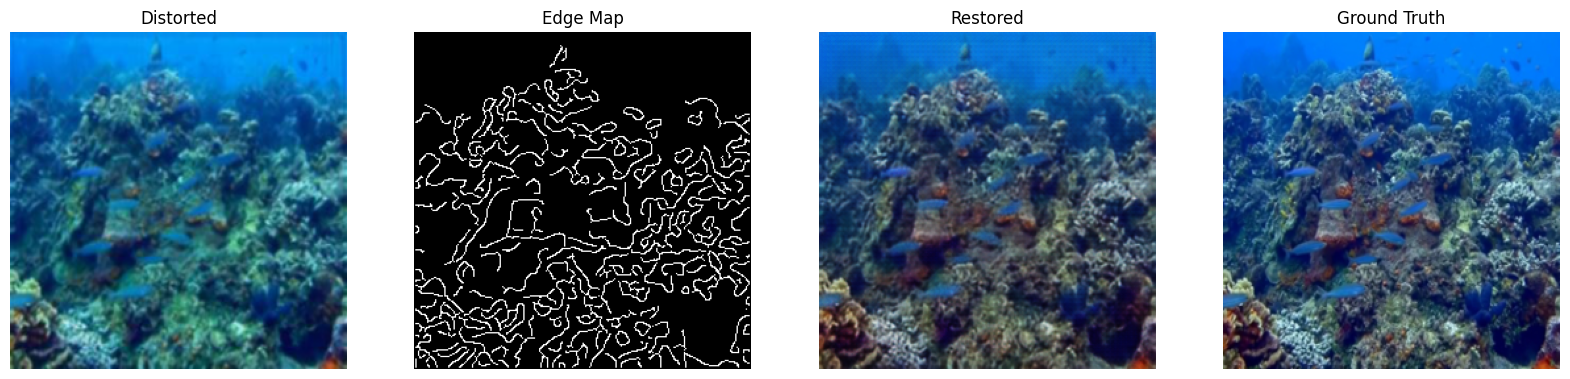

In [11]:
#8 visualization
generator.eval()
with torch.no_grad():
    distorted, ground_truth = next(iter(train_loader))
    distorted, ground_truth = distorted.to(device), ground_truth.to(device)
    fake = generator(distorted)  
    
    # Extract first image from batch and convert to NumPy
    distorted_np = distorted[0, :3].cpu().numpy().transpose(1, 2, 0)  
    ground_truth_np = ground_truth[0].cpu().numpy().transpose(1, 2, 0)  
    fake_np = fake[0].cpu().numpy().transpose(1, 2, 0) 
    edge_np = distorted[0, 3].cpu().numpy()
    
    # Plot
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))
    axs[0].imshow((distorted_np + 1) / 2); axs[0].set_title("Distorted")
    axs[1].imshow(edge_np, cmap='gray'); axs[1].set_title("Edge Map")
    axs[2].imshow((fake_np + 1) / 2); axs[2].set_title("Restored")
    axs[3].imshow((ground_truth_np + 1) / 2); axs[3].set_title("Ground Truth")
    for ax in axs:
        ax.axis('off')
    plt.show()

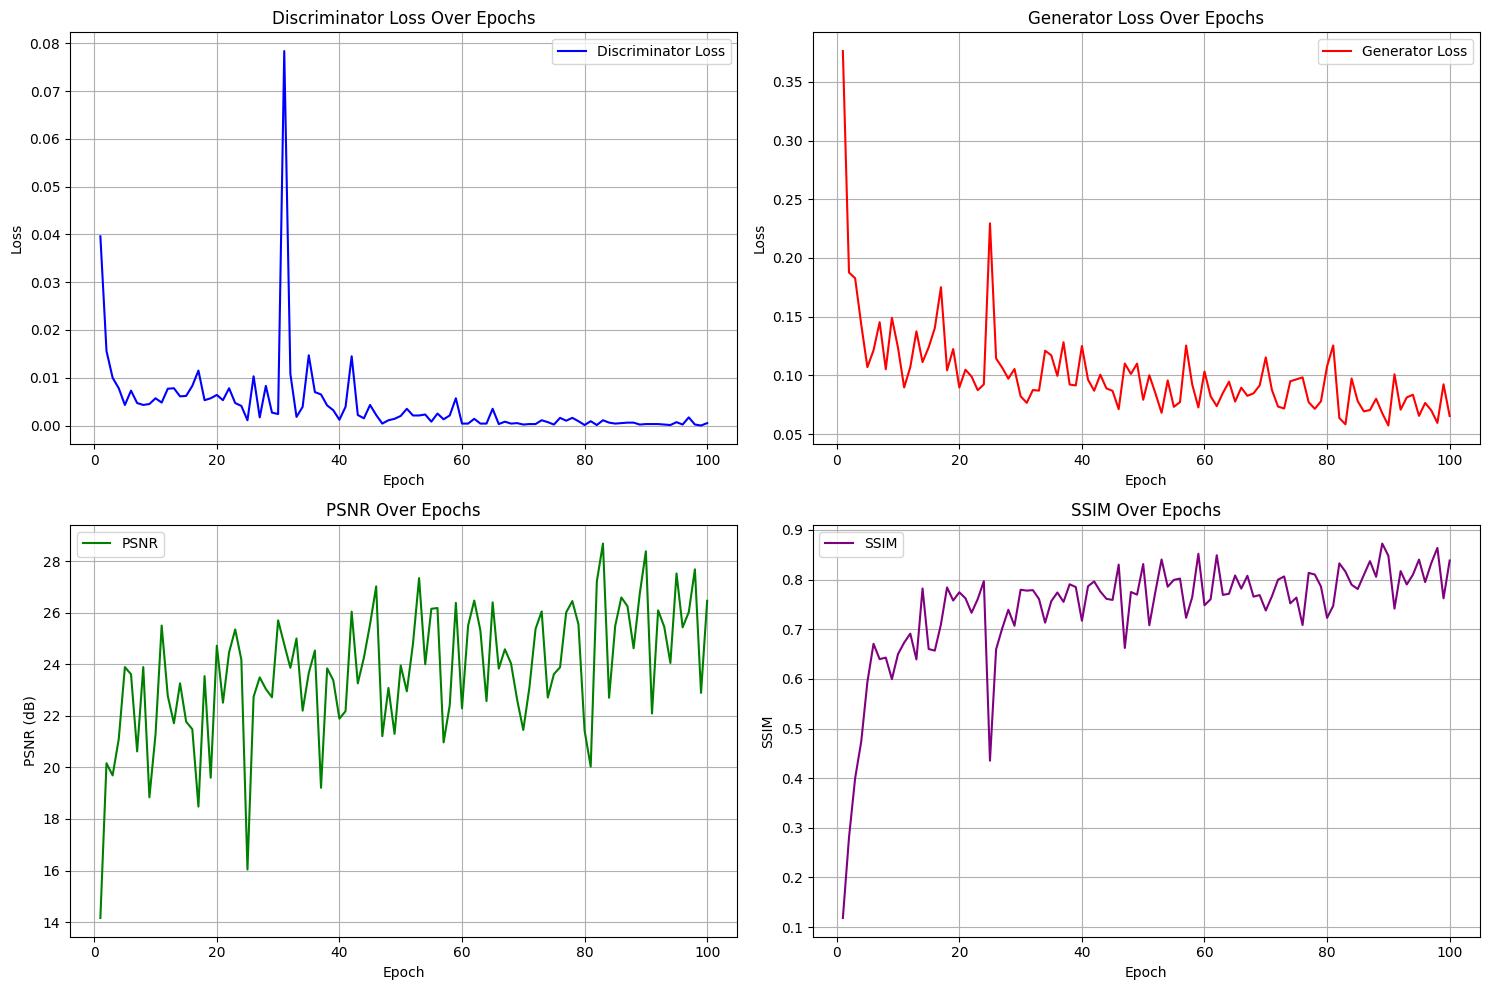

In [15]:
import matplotlib.pyplot as plt

# Data (copied from above)
epochs = list(range(1, 101))
d_loss = [0.0396, 0.0156, 0.0100, 0.0078, 0.0043, 0.0073, 0.0047, 0.0043, 0.0045, 0.0057, 0.0048, 0.0077, 0.0078, 0.0061, 0.0062, 0.0083, 0.0115, 0.0053, 0.0057, 0.0064, 0.0053, 0.0078, 0.0047, 0.0041, 0.0011, 0.0103, 0.0017, 0.0083, 0.0027, 0.0024, 0.0784, 0.0108, 0.0018, 0.0039, 0.0147, 0.0070, 0.0065, 0.0042, 0.0032, 0.0012, 0.0039, 0.0145, 0.0022, 0.0015, 0.0043, 0.0022, 0.0004, 0.0011, 0.0014, 0.0020, 0.0035, 0.0021, 0.0021, 0.0023, 0.0008, 0.0025, 0.0013, 0.0021, 0.0057, 0.0004, 0.0004, 0.0014, 0.0004, 0.0004, 0.0035, 0.0003, 0.0008, 0.0004, 0.0005, 0.0002, 0.0003, 0.0003, 0.0011, 0.0007, 0.0002, 0.0016, 0.0010, 0.0016, 0.0009, 0.0001, 0.0009, 0.0001, 0.0011, 0.0006, 0.0004, 0.0005, 0.0006, 0.0006, 0.0002, 0.0003, 0.0003, 0.0003, 0.0002, 0.0001, 0.0007, 0.0002, 0.0017, 0.0002, 0.0000, 0.0005]
g_loss = [0.3762, 0.1876, 0.1827, 0.1432, 0.1070, 0.1213, 0.1453, 0.1052, 0.1490, 0.1235, 0.0897, 0.1070, 0.1375, 0.1113, 0.1239, 0.1403, 0.1751, 0.1043, 0.1224, 0.0897, 0.1048, 0.0990, 0.0874, 0.0923, 0.2295, 0.1144, 0.1065, 0.0972, 0.1054, 0.0822, 0.0766, 0.0875, 0.0870, 0.1210, 0.1171, 0.0996, 0.1282, 0.0922, 0.0914, 0.1250, 0.0963, 0.0869, 0.1006, 0.0889, 0.0868, 0.0712, 0.1101, 0.1012, 0.1100, 0.0792, 0.1001, 0.0846, 0.0681, 0.0957, 0.0732, 0.0772, 0.1254, 0.0922, 0.0727, 0.1033, 0.0822, 0.0738, 0.0850, 0.0946, 0.0777, 0.0895, 0.0826, 0.0847, 0.0914, 0.1153, 0.0876, 0.0734, 0.0718, 0.0950, 0.0966, 0.0983, 0.0771, 0.0715, 0.0779, 0.1078, 0.1255, 0.0637, 0.0583, 0.0973, 0.0780, 0.0693, 0.0705, 0.0801, 0.0678, 0.0573, 0.1009, 0.0708, 0.0812, 0.0835, 0.0655, 0.0765, 0.0702, 0.0595, 0.0924, 0.0654]
psnr = [14.16, 20.16, 19.69, 21.10, 23.89, 23.61, 20.62, 23.89, 18.84, 21.28, 25.50, 22.77, 21.71, 23.26, 21.77, 21.48, 18.48, 23.54, 19.60, 24.72, 22.51, 24.46, 25.35, 24.18, 16.04, 22.74, 23.49, 23.04, 22.72, 25.70, 24.77, 23.86, 25.00, 22.20, 23.66, 24.53, 19.21, 23.84, 23.38, 21.89, 22.18, 26.04, 23.26, 24.26, 25.55, 27.02, 21.21, 23.08, 21.30, 23.95, 22.95, 24.79, 27.34, 24.00, 26.15, 26.18, 20.97, 22.41, 26.38, 22.29, 25.50, 26.47, 25.31, 22.57, 26.40, 23.83, 24.58, 24.03, 22.62, 21.45, 23.10, 25.37, 26.05, 22.71, 23.62, 23.88, 26.01, 26.45, 25.55, 21.43, 20.03, 27.21, 28.68, 22.70, 25.49, 26.59, 26.25, 24.62, 26.73, 28.38, 22.09, 26.09, 25.45, 24.05, 27.52, 25.43, 26.02, 27.68, 22.89, 26.46]
ssim = [0.1184, 0.2805, 0.3998, 0.4741, 0.5935, 0.6706, 0.6397, 0.6428, 0.5996, 0.6500, 0.6730, 0.6911, 0.6392, 0.7820, 0.6601, 0.6569, 0.7097, 0.7841, 0.7578, 0.7744, 0.7623, 0.7331, 0.7606, 0.7967, 0.4352, 0.6595, 0.7018, 0.7392, 0.7070, 0.7795, 0.7777, 0.7787, 0.7608, 0.7132, 0.7564, 0.7739, 0.7550, 0.7905, 0.7849, 0.7170, 0.7865, 0.7962, 0.7760, 0.7612, 0.7590, 0.8301, 0.6622, 0.7749, 0.7697, 0.8312, 0.7080, 0.7762, 0.8404, 0.7855, 0.7993, 0.8020, 0.7230, 0.7647, 0.8518, 0.7482, 0.7604, 0.8490, 0.7691, 0.7714, 0.8082, 0.7818, 0.8077, 0.7656, 0.7687, 0.7377, 0.7662, 0.7997, 0.8063, 0.7521, 0.7637, 0.7084, 0.8134, 0.8101, 0.7860, 0.7228, 0.7471, 0.8326, 0.8159, 0.7896, 0.7809, 0.8092, 0.8371, 0.8055, 0.8725, 0.8480, 0.7415, 0.8170, 0.7901, 0.8096, 0.8402, 0.7949, 0.8330, 0.8637, 0.7623, 0.8383]

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Plot D Loss
axs[0, 0].plot(epochs, d_loss, label='Discriminator Loss', color='blue')
axs[0, 0].set_title('Discriminator Loss Over Epochs')
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].legend()
axs[0, 0].grid(True)

# Plot G Loss
axs[0, 1].plot(epochs, g_loss, label='Generator Loss', color='red')
axs[0, 1].set_title('Generator Loss Over Epochs')
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].legend()
axs[0, 1].grid(True)

# Plot PSNR
axs[1, 0].plot(epochs, psnr, label='PSNR', color='green')
axs[1, 0].set_title('PSNR Over Epochs')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].set_ylabel('PSNR (dB)')
axs[1, 0].legend()
axs[1, 0].grid(True)

# Plot SSIM
axs[1, 1].plot(epochs, ssim, label='SSIM', color='purple')
axs[1, 1].set_title('SSIM Over Epochs')
axs[1, 1].set_xlabel('Epoch')
axs[1, 1].set_ylabel('SSIM')
axs[1, 1].legend()
axs[1, 1].grid(True)

# Adjust layout
plt.tight_layout()
plt.savefig("plots.png", dpi=300, bbox_inches='tight')
plt.show()

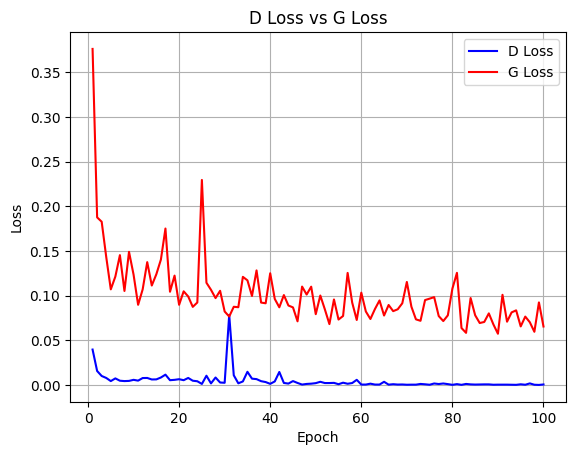

In [13]:
plt.plot(epochs, d_loss, label='D Loss', color='blue')
plt.plot(epochs, g_loss, label='G Loss', color='red')
plt.title('D Loss vs G Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig("d_lossVsg_loss.png", dpi=300, bbox_inches='tight')
plt.show()

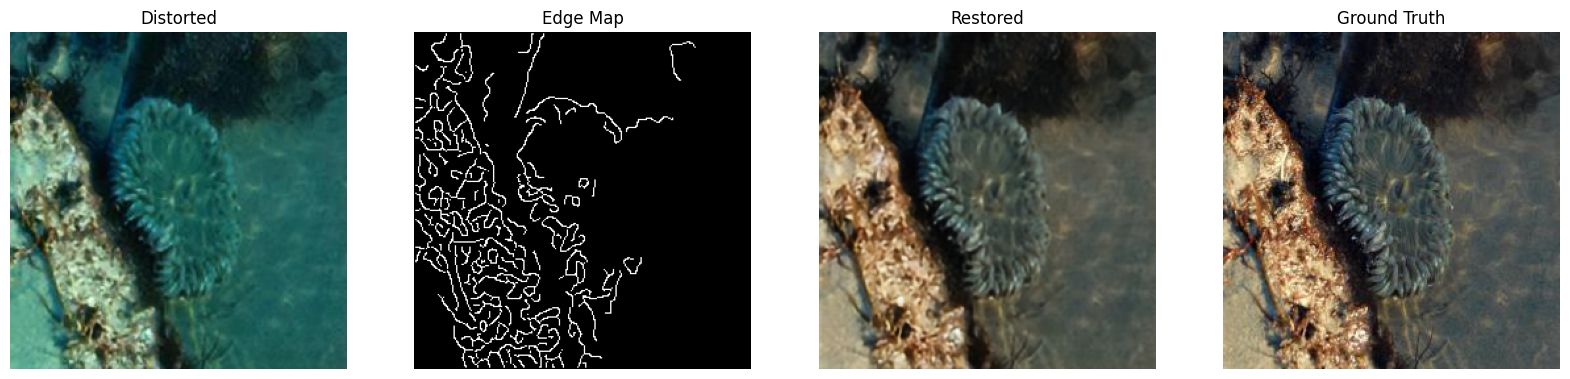

In [12]:
# Cell 8: Qualitative Visualization
generator.load_state_dict(torch.load("generator_epoch_90.pth"))  # Peak PSNR
generator.eval()
with torch.no_grad():
    distorted, ground_truth = next(iter(train_loader))
    distorted, ground_truth = distorted.to(device), ground_truth.to(device)
    fake = generator(distorted)
    
    distorted_np = distorted[0, :3].cpu().numpy().transpose(1, 2, 0)
    ground_truth_np = ground_truth[0].cpu().numpy().transpose(1, 2, 0)
    fake_np = fake[0].cpu().numpy().transpose(1, 2, 0)
    edge_np = distorted[0, 3].cpu().numpy()
    
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))
    axs[0].imshow((distorted_np + 1) / 2); axs[0].set_title("Distorted")
    axs[1].imshow(edge_np, cmap='gray'); axs[1].set_title("Edge Map")
    axs[2].imshow((fake_np + 1) / 2); axs[2].set_title("Restored")
    axs[3].imshow((ground_truth_np + 1) / 2); axs[3].set_title("Ground Truth")
    for ax in axs: ax.axis('off')
    plt.savefig("restoration_results.png", dpi=300, bbox_inches='tight')
    plt.show()

In [37]:
# Cell 11: Test Set Evaluation
from torch.utils.data import Subset
import numpy as np

# Split dataset (90% train, 10% test)
indices = np.arange(len(dataset))
np.random.shuffle(indices)
train_size = int(0.9 * len(dataset))
train_indices, test_indices = indices[:train_size], indices[train_size:]
test_dataset = Subset(dataset, test_indices)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# Evaluate
generator.eval()
psnr_list, ssim_list = [], []
with torch.no_grad():
    for distorted, ground_truth in test_loader:
        distorted, ground_truth = distorted.to(device), ground_truth.to(device)
        fake = generator(distorted)
        psnr_list.append(peak_signal_noise_ratio(fake, ground_truth, data_range=2.0).item())
        ssim_list.append(structural_similarity_index_measure(fake, ground_truth, data_range=2.0).item())

mean_psnr, mean_ssim = np.mean(psnr_list), np.mean(ssim_list)
print(f"Test Set - Mean PSNR: {mean_psnr:.2f}, Mean SSIM: {mean_ssim:.4f}")

Test Set - Mean PSNR: 25.66, Mean SSIM: 0.8205
